In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import scipy.stats as stats

/usr/local/lib/python3.7/site-packages/pandas/core/ops/__init__.py:1115: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  result = method(y)


FastME p-distance 1000M1 -0.3008585289076464 0.7652531808284575
FastME JC69 1000M1 0.16382566453037475 0.8708107776593718
FastME K2P 1000M1 -0.18426139935138897 0.8562763549601803
FastME p-distance 1000M4 -0.16427448822276783 0.87038576122364
FastME JC69 1000M4 0.11058763560186921 0.9125575850079575
FastME K2P 1000M4 0.1491539115142244 0.8822422082968591


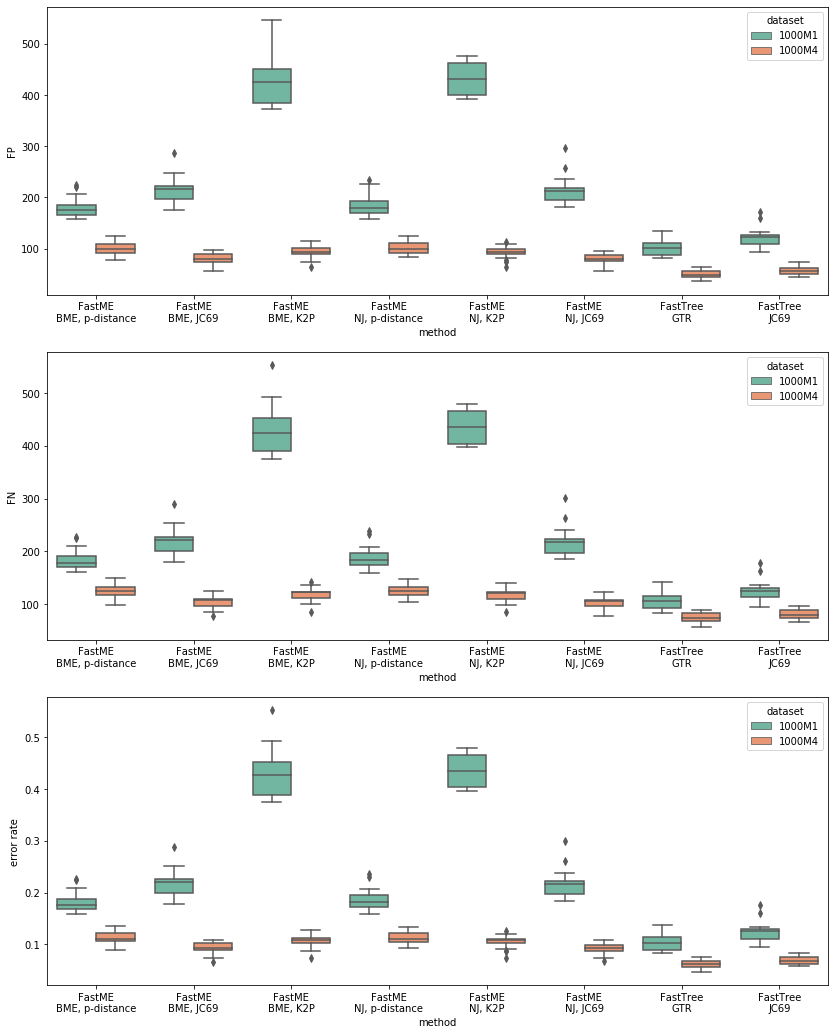

In [27]:
datasets = ['1000M1', '1000M4']
columns = ['method', 'repetition', 'FP', 'FN']
n = 1000

# read in results from FastME - BalME and NJ
prefix_bme, suffix_bme = 'FastME-TaxAdd_BalME/result_', '_fastme_taxadd.txt'
prefix_nj, suffix_nj = 'NJ/result_', '_nj.txt'

# read in results from FastTree - GTR and JC
prefix_ft, suffix_ft = 'FastTree/result_', '_fasttree.txt'

fig, ax = plt.subplots(3,1, figsize=(14,18))
i = 0
dataset_df = []
for d in datasets:
    bme_f = prefix_bme+d+suffix_bme
    nj_f = prefix_nj+d+suffix_nj
    ft_f = prefix_ft+d+suffix_ft

    bme = pd.read_csv(bme_f, names=columns, header=None)
    nj = pd.read_csv(nj_f, names=columns, header=None)
    ft = pd.read_csv(ft_f, names=columns, header=None)

    bme, nj, ft = bme[bme.FP != 'err'], nj[nj.FP != 'err'], ft[ft.FP != 'err']
    nj.loc[nj.method == 'p-distance', 'method'] = 'FastME\nNJ, p-distance'
    nj.loc[nj.method == 'JC69', 'method'] = 'FastME\nNJ, JC69'
    nj.loc[nj.method == 'K2P', 'method'] = 'FastME\nNJ, K2P'
    bme.loc[bme.method == 'p-distance', 'method'] = 'FastME\nBME, p-distance'
    bme.loc[bme.method == 'JC69', 'method'] = 'FastME\nBME, JC69'
    bme.loc[bme.method == 'K2P', 'method'] = 'FastME\nBME, K2P'

    combined = pd.concat([bme, nj, ft], ignore_index=True)
    #combined = combined[combined.method != 'K2P']
    combined.loc[combined.method == 'GTR', 'method'] = 'FastTree\nGTR'
    combined.loc[combined.method == 'JC', 'method'] = 'FastTree\nJC69'
    combined[['FP', 'FN']] = combined[['FP', 'FN']].apply(pd.to_numeric)
    combined['dataset'] = d
    combined['error rate'] = (combined['FP'] + combined['FN']) / (2*n-6)
    dataset_df.append(combined)
    i += 1

combined_df = pd.concat(dataset_df, ignore_index=True)

# stat test
methods = ['p-distance', 'JC69', 'K2P']
datasets = ['1000M1', '1000M4']
for d in datasets:
    for m in methods:
        s, p = stats.ttest_ind(combined_df.loc[(combined_df.method == 'FastME\nBME, {}'.format(m)) & (combined_df.dataset == d), 'error rate'].to_numpy(),
                combined_df.loc[(combined_df.method == 'FastME\nNJ, {}'.format(m)) & (combined_df.dataset == d), 'error rate'].to_numpy(),
                      nan_policy='omit')
        print('FastME', m, d, s, p)

sns.boxplot(x='method', y='FP', data=combined_df, hue='dataset', palette="Set2", ax=ax[0])
sns.boxplot(x='method', y='FN', data=combined_df, hue='dataset', palette="Set2", ax=ax[1])
sns.boxplot(x='method', y='error rate', data=combined_df, hue='dataset', palette="Set2", ax=ax[2])


#fig.text(0.04, 0.5, '', va='center', rotation='vertical')
fig.savefig("evaluation.jpg", dpi=400)
